# Basics

This example demonstrates the basics of neural operators in Continuity,
including how to train it on a given operator.

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from continuity.operators import DeepONet
from continuity.data import OperatorDataset
from continuity.trainer import Trainer

In [2]:
torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Problem

Let's assume we want to learn the derivative operator for some $u\in U$ and $v\in V$

$$D: U \mapsto V,$$

where $U$ and $V$ are some function spaces.
For this notebook we choose $u(x)=\sin(x)$ and the derivative $v(y)=\cos(y)$ with $x, y\in \mathbb{R}$ on the interval $[-\pi, \pi]$. For the derivative $x$ and $y$ are from the same space. For other operators, the spaces may differ.

Let's start with defining and plotting input and target function!

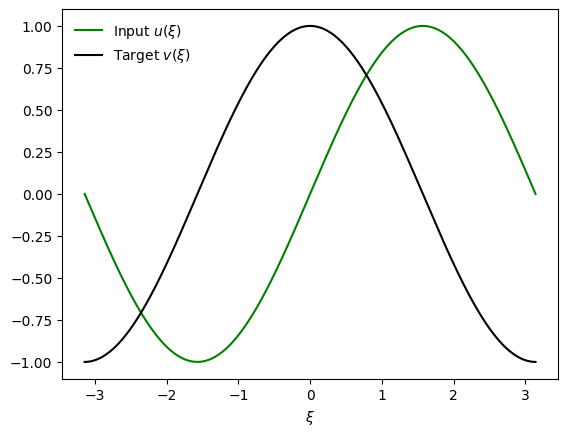

In [3]:
# Input function (some example)
u = lambda chi: torch.sin(chi)

# Target function (the derivative of u)
v = lambda chi: torch.cos(chi)

# Domain parameters
L = torch.pi
xi = torch.linspace(-L, L, 1000)  # from the same domain as y and x to plot "continuous" representations of u and v

# Plot input and target function
plt.plot(xi, u(xi), "g-", label=r"Input $u(\xi)$")
plt.plot(xi, v(xi), "k-", label=r"Target $v(\xi)$")
plt.xlabel(r"$\xi$")
plt.legend()
plt.show()

## Dataset
The goal is to learn a mapping between two infinite dimensional spaces. To work with them numerically, we assume that we only have access to point-wise evaluations of these functions. In continuity these discretized functions are described in a `OperatorDataset`. In this case, we probe $u$ with 32 sensors and evaluate $v$ in 100 points.


In [4]:
num_sensors = 32
num_evaluations = 100
x = torch.linspace(-L, L, num_sensors)
y = torch.linspace(-L, L, num_evaluations)

# This dataset contains only a single sample (first dimension of all tensors)
n_observations = 1
u_dim = x_dim = y_dim = v_dim = 1
dataset = OperatorDataset(
    x=x.reshape(n_observations, num_sensors, x_dim),
    u=u(x).reshape(n_observations, num_sensors, u_dim),
    y=y.reshape(n_observations, num_evaluations, y_dim),
    v=v(y).reshape(n_observations, num_evaluations, v_dim)
)
data_loader = DataLoader(dataset)

## Operator

To learn operator $G$ with a neural network, we can train a _neural operator_.

A neural operator takes an input function $u$, evaluated at collocation points $x$, and maps it to a function $v$ evaluated at (different) evaluation positions $y$:
$$
v(y) = G(u)(y) \approx G_\theta\left(x, u(x), y\right).
$$

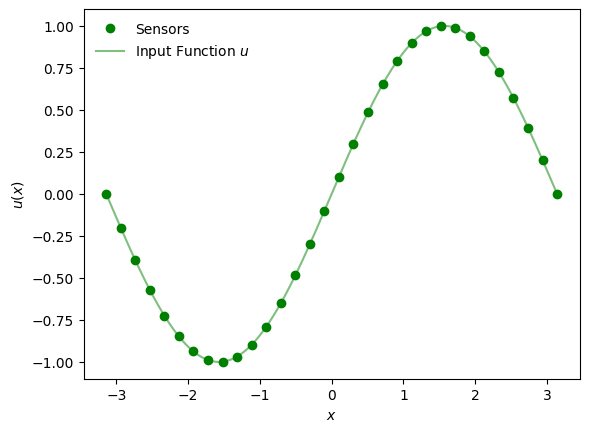

In [5]:
# Define operator
operator = DeepONet(shapes=dataset.shapes)

# Plot sensors
plt.plot(x, u(x), "go", label="Sensors")
plt.plot(xi, u(xi), "g-", alpha=0.5, label="Input Function $u$")
plt.xlabel("$x$")
plt.ylabel("$u(x)$")
plt.legend()
plt.show()

## Plotting

Before we train the neural operator, let us show how to evaluate the (untrained)
neural operator and plot the result.

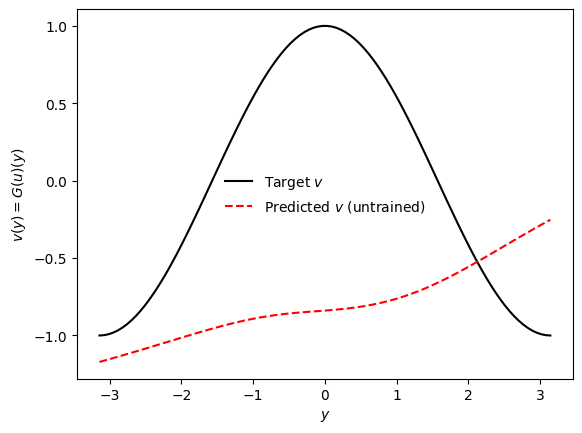

In [6]:
# Call operator
x_i, u_i, y_i, v_i = dataset[:]  # get instances of x, u, y, i (in this case one)
v_pred = operator(x_i, u_i, y_i)

# Plot the predicted function
plt.plot(y_i.squeeze(), v_i.squeeze(), "k-", label="Target $v$")
plt.plot(y_i.squeeze(), v_pred.detach().squeeze(), "r--", label="Predicted $v$ (untrained)")
plt.xlabel("$y$")
plt.ylabel("$v(y)=G(u)(y)$")
plt.legend()
plt.show()

## Training

Now, let's train the neural operator!

We define a corresponding data set, i.e., a list-like of input-output samples.

Using Adam, we train the neural operator for 1000 epochs. 

In [7]:
trainer = Trainer(operator)
trainer.fit(data_loader, epochs=1000)

Model parameters: 7984
Epoch 1000:  loss/train = 1.2350e-04  (0.000881 s/epoch)


## Evaluating

The mapping of the trained operator can be evaluated at arbitrary positions,
so let's plot with a fine resolution along with the target function.

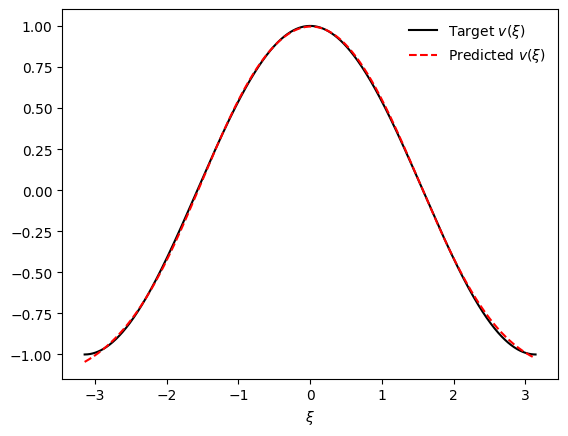

In [8]:
# Call operator with more points
y_plot = xi.reshape(n_observations, -1, y_dim)
v_pred = operator(x_i, u_i, y_plot).squeeze()

# Plot output and target function
plt.plot(xi.squeeze(), v(xi).squeeze(), "k-", label=r"Target $v(\xi)$")
plt.plot(y_plot.squeeze(), v_pred.detach(), "r--", label=r"Predicted $v(\xi)$")
plt.xlabel(r"$\xi$")
plt.legend()
plt.show()

As you can see, the operator output (approximately) matches $v$, as desired.
That's the basics!

In the other examples, we explore advanced features such as 
physics-informed training, self-supervised training, or super-resolution.